In [1]:
pip install catboost xgboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from sklearn.base import clone
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('train_c.csv')

**График целевой переменной (с выбросами):**

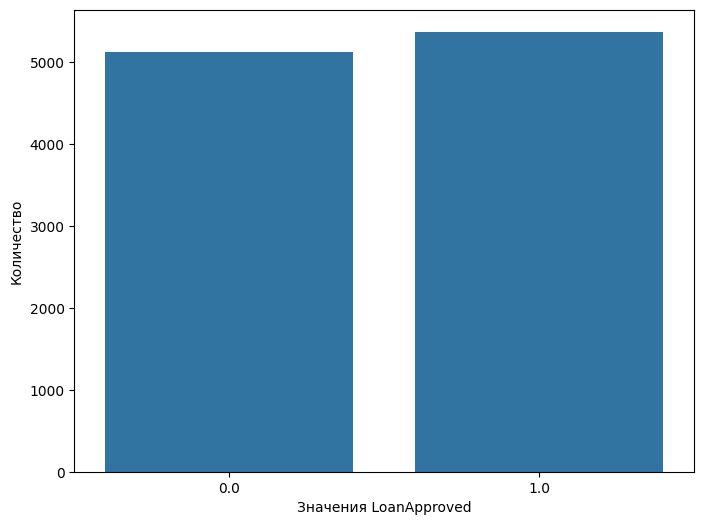

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='LoanApproved', data=data)
plt.xlabel('Значения LoanApproved')
plt.ylabel('Количество')
plt.show()

In [5]:
data_copy = data.copy().drop('ApplicationDate', axis=1)

In [6]:
categorical_cols = data_copy.select_dtypes(include=['object', 'category']).columns

data_copy = pd.get_dummies(data_copy, columns=categorical_cols)

data_copy = data_copy.astype(float)

**Матрица корреляций (с выбросами):**

In [7]:
corr_matrix = data_copy.corr()

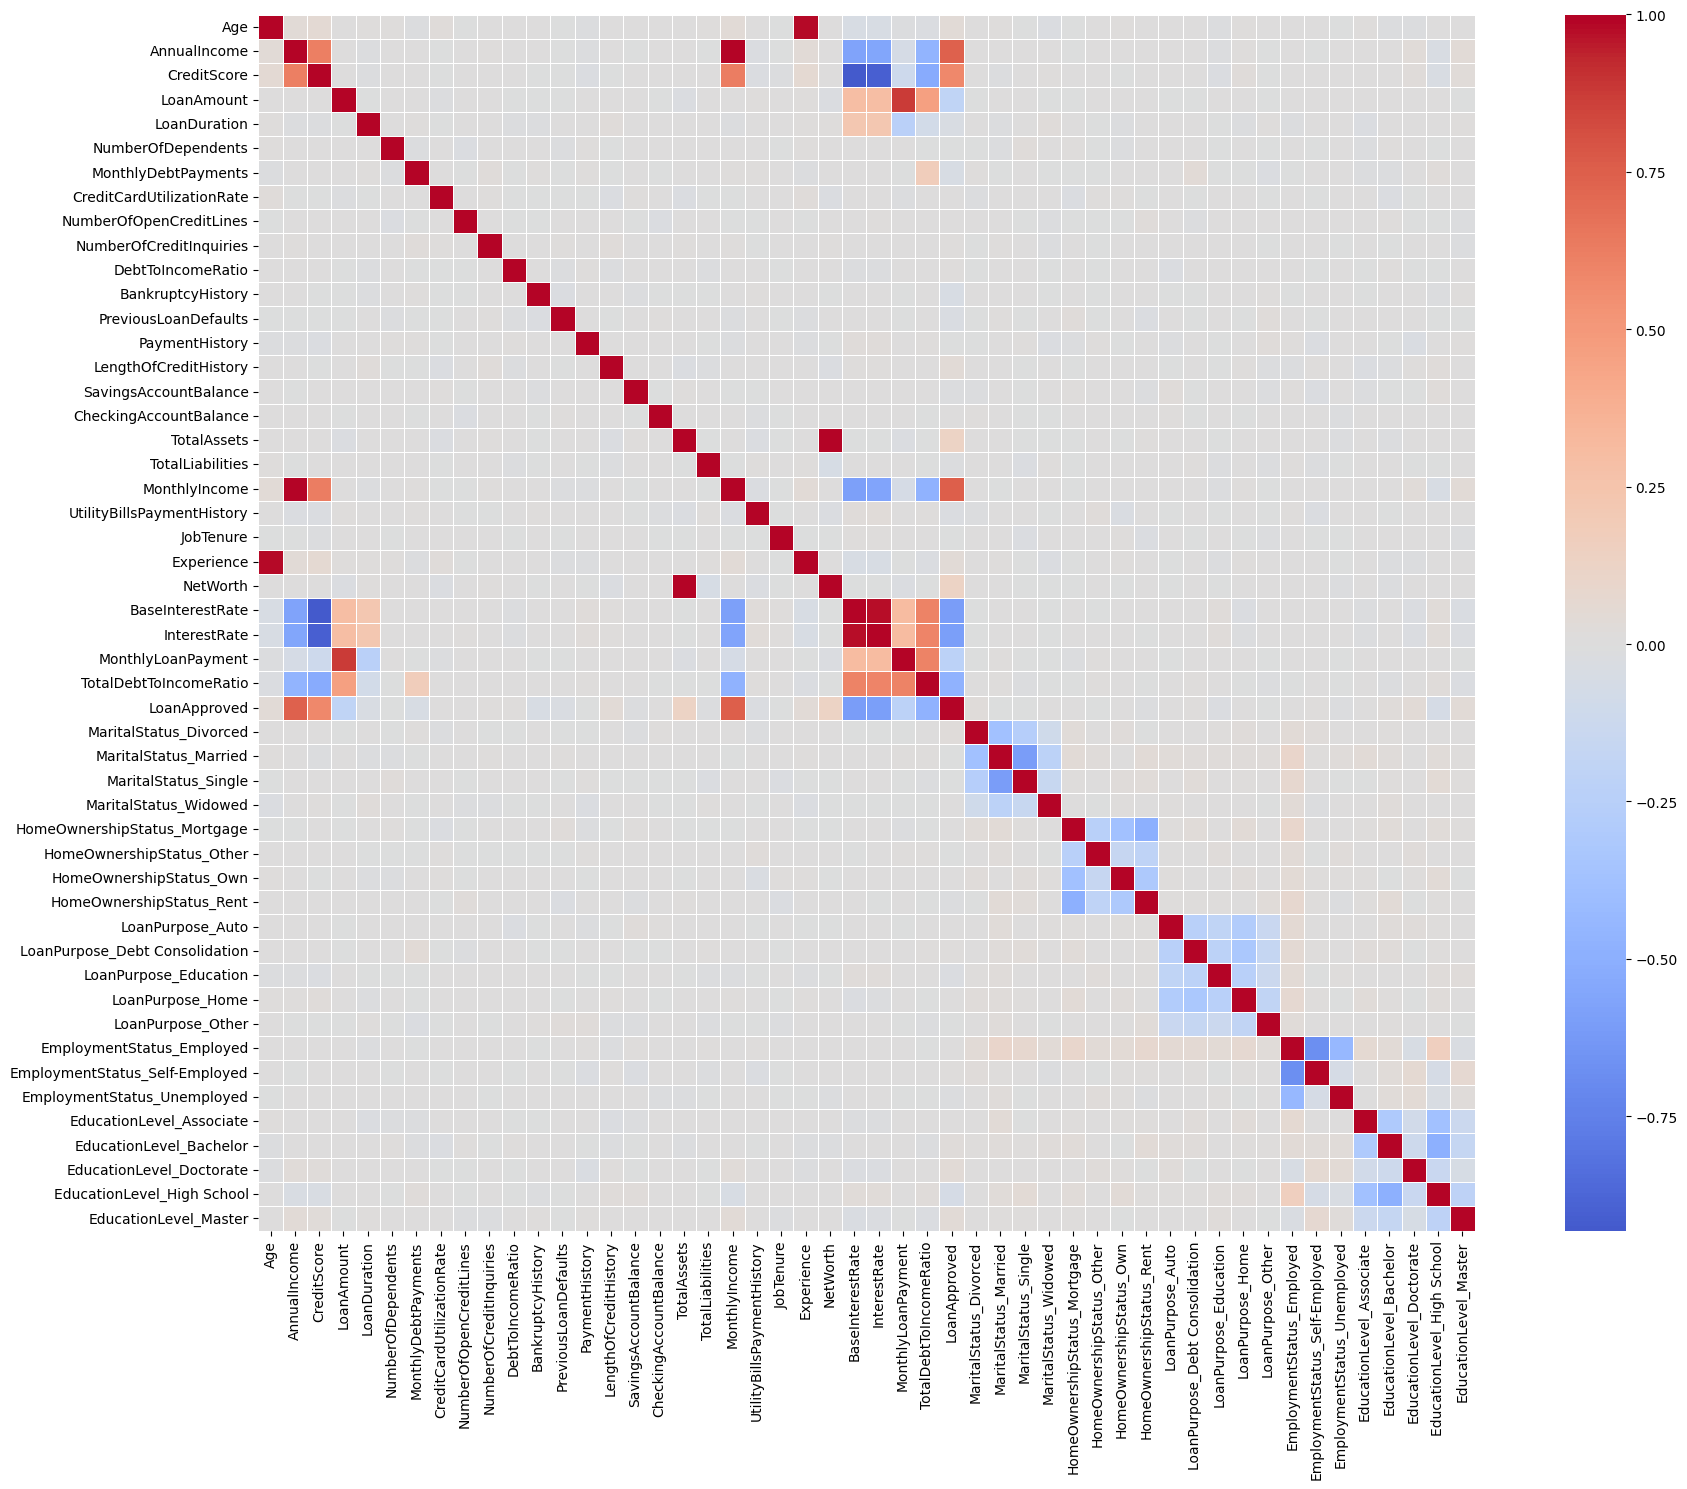

In [8]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)

plt.tight_layout()

In [9]:
def drop_outliers(df, col=None, cutoff=6):
  df_copy = df.copy()

  if col is not None:
    numeric_cols = [col]
  else:
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns

  mask = pd.Series(False, index=df_copy.index)

  for ncol in numeric_cols:
    z_vals = (df_copy[ncol] - df_copy[ncol].mean()) / df_copy[ncol].std()
    mask = mask | (z_vals.abs() > cutoff)

  return df_copy[~mask]

In [10]:
def impute_missing_data(df):
  result = df.copy()

  num_cols = result.select_dtypes(include=[np.number]).columns
  if 'LoanApproved' in num_cols:
    num_cols = num_cols.drop('LoanApproved')

  result[num_cols] = result[num_cols].fillna(result[num_cols].median())

  return result

In [11]:
data_clean = drop_outliers(data_copy, cutoff=6)
data_clean = data_clean.dropna(subset=['LoanApproved'])
data_clean = impute_missing_data(data_clean)

**График целевой переменной (без выбросов):**

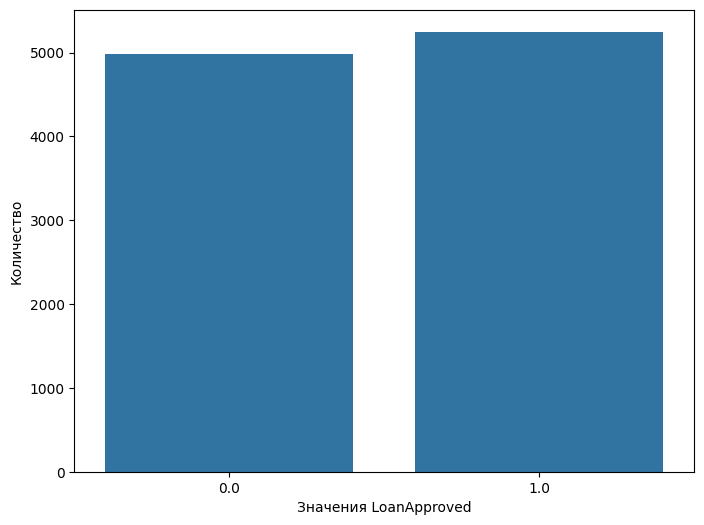

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='LoanApproved', data=data_clean)
plt.xlabel('Значения LoanApproved')
plt.ylabel('Количество')
plt.show()

**Матрица корреляций (без выбросов):**

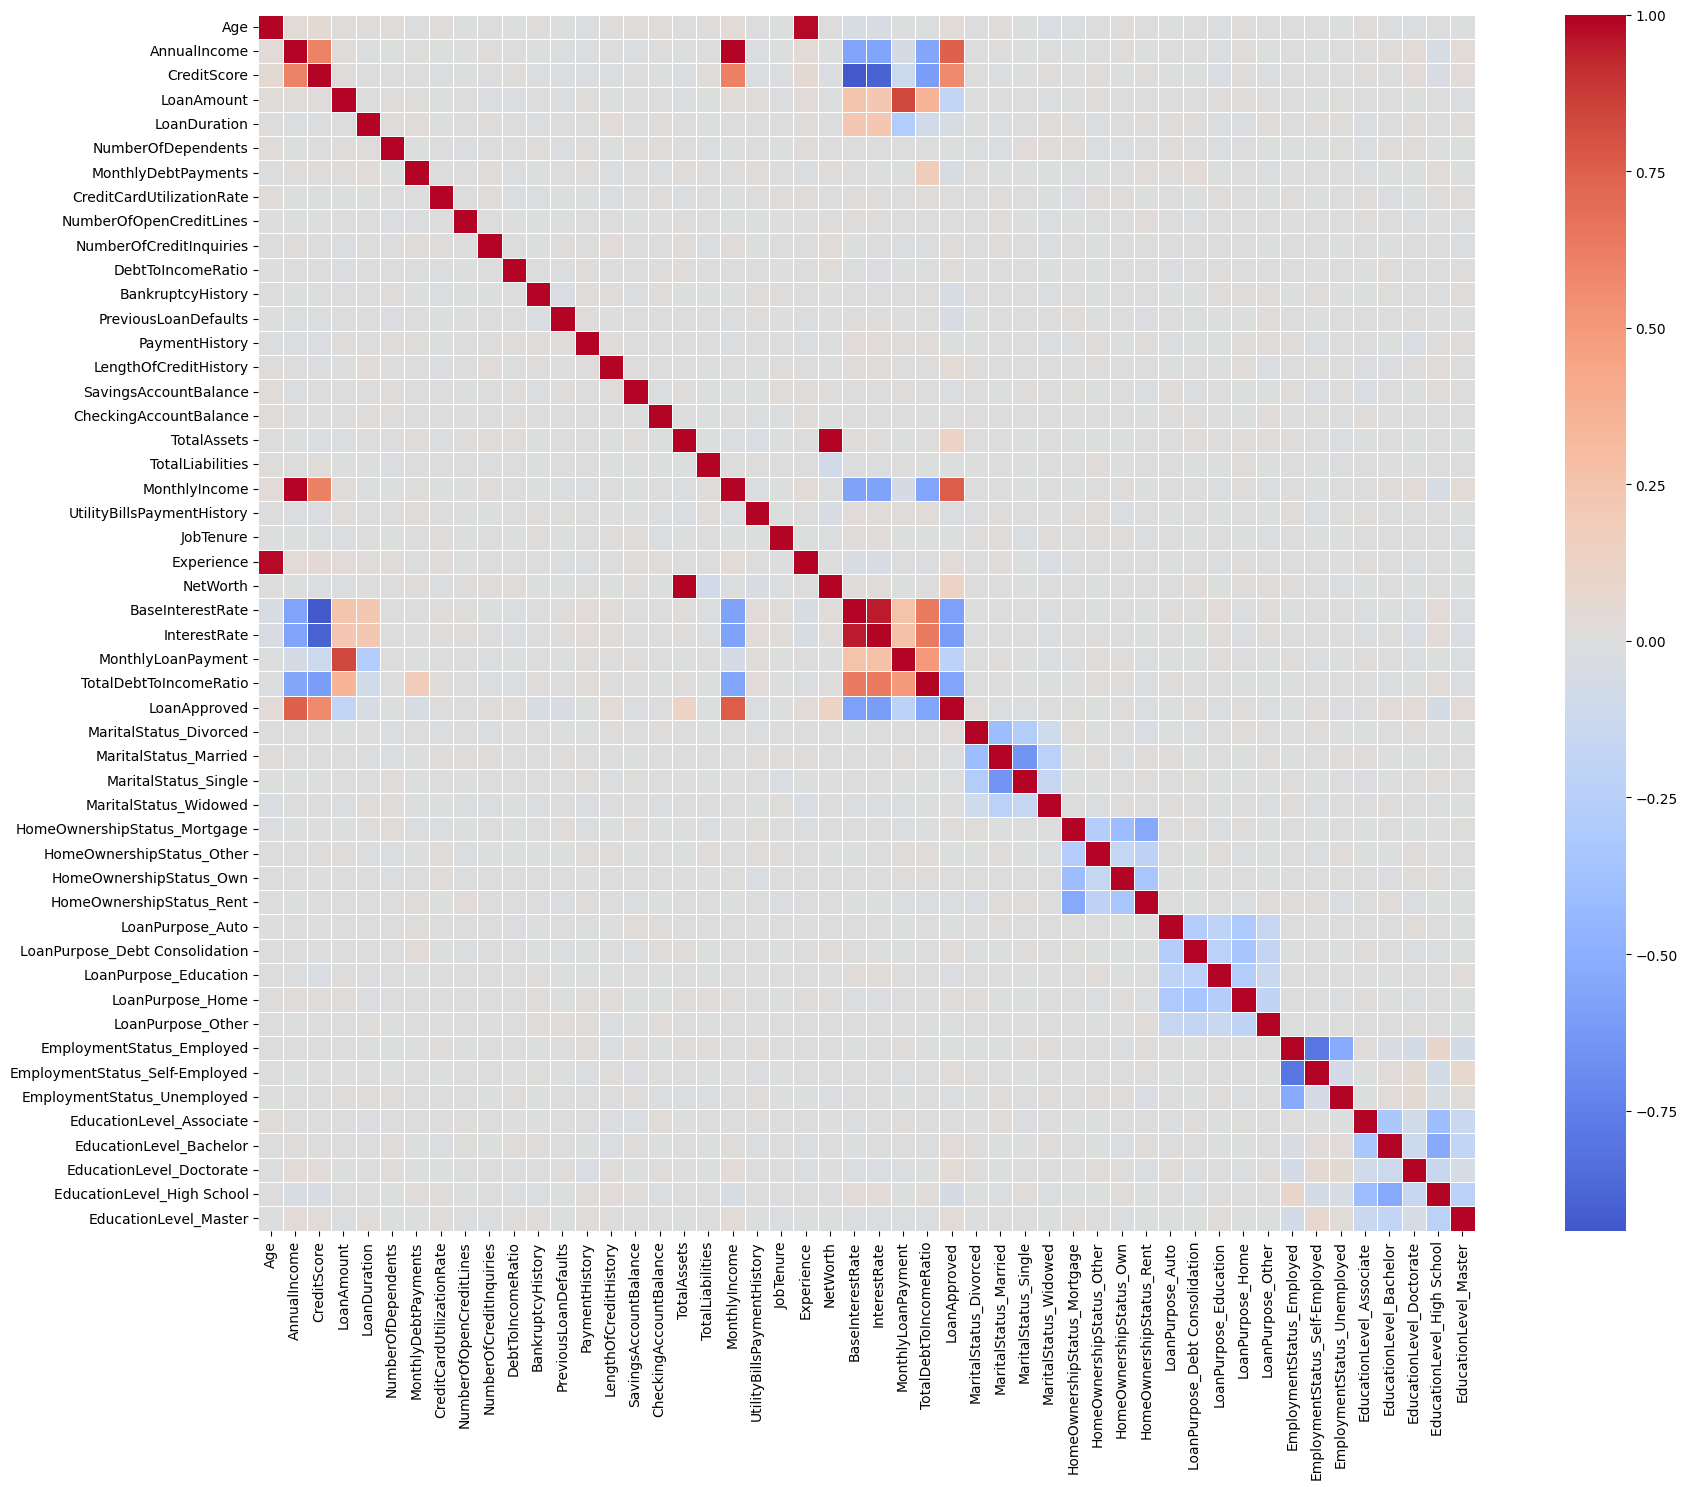

In [13]:
corr_matrix = data_clean.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)

plt.tight_layout()

In [14]:
X = data_clean.drop('LoanApproved', axis=1)
y = data_clean['LoanApproved']

y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
class CustomBaggingClassifier:
  def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0, random_state=None):
    self.base_estimator = base_estimator or DecisionTreeClassifier()
    self.n_estimators = n_estimators
    self.max_samples = max_samples
    self.random_state = random_state
    self.estimators_ = []

  def fit(self, X, y):
    np.random.seed(self.random_state)
    n_samples = X.shape[0]
    n_bootstrap = int(n_samples * self.max_samples)

    self.estimators_ = []
    for i in range(self.n_estimators):
      indices = np.random.choice(n_samples, n_bootstrap, replace=True)
      X_boot = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
      y_boot = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

      estimator = self.base_estimator.__class__(**self.base_estimator.get_params())
      estimator.fit(X_boot, y_boot)
      self.estimators_.append(estimator)
    return self

  def predict_proba(self, X):
    probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
    avg_proba = np.mean(probas, axis=0)
    return avg_proba

  def predict(self, X):
    probas = self.predict_proba(X)
    return np.argmax(probas, axis=1)

In [16]:
custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)
custom_bagging.fit(X_train, y_train)
y_proba_custom_bg = custom_bagging.predict_proba(X_test)[:, 1]
custom_bg_roc_auc = roc_auc_score(y_test, y_proba_custom_bg)
print(custom_bg_roc_auc)

0.965833691550843


In [17]:
sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    random_state=42
)
sklearn_bagging.fit(X_train, y_train)
y_proba_sklearn_bg = sklearn_bagging.predict_proba(X_test)[:, 1]
sklearn_bg_roc_auc = roc_auc_score(y_test, y_proba_sklearn_bg)
print(sklearn_bg_roc_auc)

0.9662668959258727


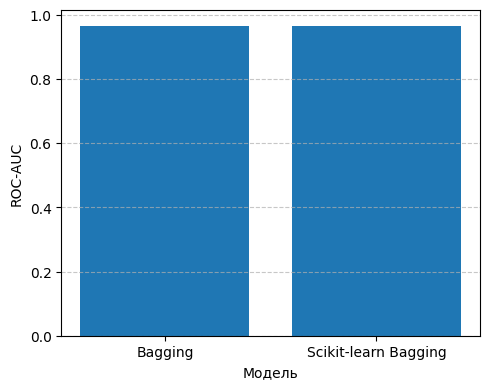

In [18]:
roc_auc_values = [custom_bg_roc_auc, sklearn_bg_roc_auc]
models = ['Bagging', 'Scikit-learn Bagging']

plt.figure(figsize=(5, 4))
plt.bar(models, roc_auc_values)
plt.xlabel('Модель')
plt.ylabel('ROC-AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [19]:
class CustomGradientBoosting:
  def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.random_state = random_state
    self.trees = []

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def fit(self, X, y):
    np.random.seed(self.random_state)
    F = np.zeros(len(y))
    self.trees = []

    for i in range(self.n_estimators):
      p = self.sigmoid(F)
      residuals = y - p

      tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state+i)
      tree.fit(X, residuals)

      F += self.learning_rate * tree.predict(X)
      self.trees.append(tree)
    return self

  def predict_proba(self, X):
    F = np.zeros(X.shape[0])
    for tree in self.trees:
      F += self.learning_rate * tree.predict(X)
    probs = self.sigmoid(F)
    return np.vstack([1-probs, probs]).T

  def predict(self, X):
    probs = self.predict_proba(X)[:, 1]
    return (probs > 0.5).astype(int)

In [20]:
custom_gb = CustomGradientBoosting(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
custom_gb.fit(X_train, y_train)
y_proba_custom_gb = custom_gb.predict_proba(X_test)[:, 1]
custom_gb_roc_auc = roc_auc_score(y_test, y_proba_custom_gb)
print(custom_gb_roc_auc)

0.969074365955008


In [21]:
sklearn_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sklearn_gb.fit(X_train, y_train)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_test)[:, 1]
sklearn_gb_roc_auc = roc_auc_score(y_test, y_proba_sklearn_gb)
print(sklearn_gb_roc_auc)

0.9752027511104744


In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_test],
    callbacks=[lgb.log_evaluation(0)]
)

y_proba_lgb = lgb_model.predict(X_test)
lgb_roc_auc = roc_auc_score(y_test, y_proba_lgb)
print(lgb_roc_auc)

0.9799073410708316


In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'verbosity': 0
}

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    verbose_eval=False
)

y_proba_xgb = xgb_model.predict(dtest)
xgb_roc_auc = roc_auc_score(y_test, y_proba_xgb)
print(xgb_roc_auc)

0.9801557052108707


In [24]:
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    random_state=42,
    verbose=False
)
catboost_model.fit(X_train, y_train)
y_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]
catboost_roc_auc = roc_auc_score(y_test, y_proba_catboost)
print(catboost_roc_auc)

0.9789482733916034


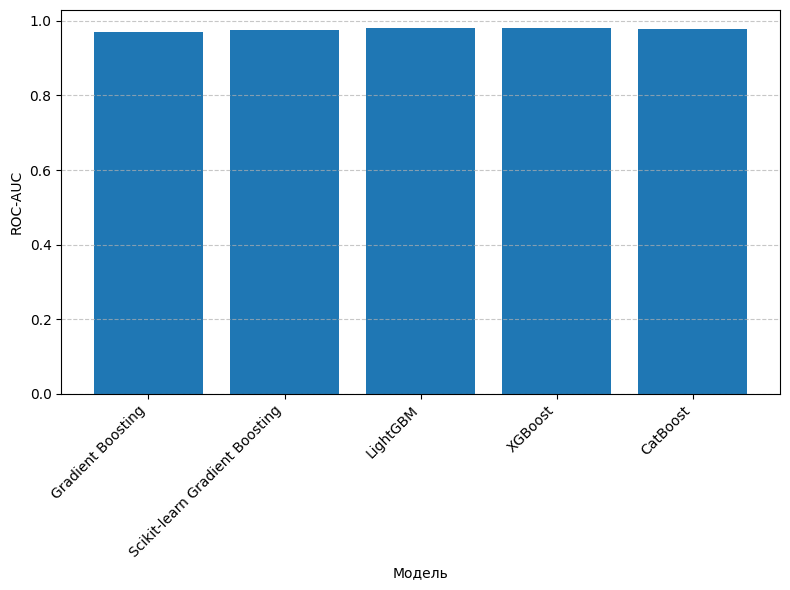

In [25]:
roc_auc_values = [custom_gb_roc_auc, sklearn_gb_roc_auc, lgb_roc_auc, xgb_roc_auc, catboost_roc_auc]
models = ['Gradient Boosting', 'Scikit-learn Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost']

plt.figure(figsize=(8, 6))
plt.bar(models, roc_auc_values)
plt.xlabel('Модель')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [26]:
y_pred_catboost = catboost_model.predict(X_test)

In [27]:
def custom_accuracy(y_true, y_pred):
  if len(y_true) != len(y_pred):
    raise ValueError()

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  correct = np.sum(y_true == y_pred)

  return correct / len(y_true)

In [28]:
catboost_acc = accuracy_score(y_test, y_pred_catboost)
catboost_custom_acc = custom_accuracy(y_test, y_pred_catboost)
print(catboost_acc == catboost_custom_acc)

True


In [29]:
def custom_precision(y_true, y_pred, pos_label=1):
  if len(y_true) != len(y_pred):
    raise ValueError()

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  tp = np.sum((y_true == pos_label) & (y_pred == pos_label))

  fp = np.sum((y_true != pos_label) & (y_pred == pos_label))

  if tp + fp == 0:
    return 0.0

  return tp / (tp + fp)

In [30]:
catboost_precision = precision_score(y_test, y_pred_catboost, pos_label=1, zero_division=0)
catboost_custom_precision = custom_precision(y_test, y_pred_catboost, pos_label=1)
print(catboost_precision == catboost_custom_precision)

True


In [31]:
def custom_recall(y_true, y_pred, pos_label=1):
  y_true, y_pred = np.array(y_true), np.array(y_pred)

  tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
  fn = np.sum((y_true == pos_label) & (y_pred != pos_label))

  return tp / (tp + fn) if (tp + fn) > 0 else 0.0

In [32]:
catboost_recall = recall_score(y_test, y_pred_catboost, pos_label=1, zero_division=0)
catboost_custom_recall = custom_recall(y_test, y_pred_catboost, pos_label=1)
print(catboost_recall == catboost_custom_recall)

True


In [33]:
def custom_f1(y_true, y_pred, pos_label=1):
  y_true, y_pred = np.array(y_true), np.array(y_pred)

  tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
  fp = np.sum((y_true != pos_label) & (y_pred == pos_label))
  fn = np.sum((y_true == pos_label) & (y_pred != pos_label))

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

  return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

In [34]:
catboost_f1 = f1_score(y_test, y_pred_catboost)
catboost_custom_f1 = custom_f1(y_test, y_pred_catboost)
print(catboost_f1 == catboost_custom_f1)

True


In [35]:
def custom_roc_auc(y_true, y_score, pos_label=1):
  y_true = np.array(y_true)
  y_score = np.array(y_score)

  desc_score_indices = np.argsort(y_score)[::-1]
  y_true_sorted = y_true[desc_score_indices]
  y_score_sorted = y_score[desc_score_indices]

  unique_scores, inverse_indices = np.unique(y_score_sorted, return_inverse=True)
  ranks = np.zeros_like(y_score_sorted, dtype=float)

  for i, score in enumerate(unique_scores):
    mask = inverse_indices == i
    start_rank = np.sum(mask) + 2 * np.sum(ranks > 0) + 1
    ranks[mask] = start_rank / 2

  pos_ranks_sum = np.sum(ranks[y_true_sorted == pos_label])

  n_pos = np.sum(y_true == pos_label)
  n_neg = len(y_true) - n_pos

  if n_pos == 0 or n_neg == 0:
    return 0.0

  auc = (pos_ranks_sum - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)

  return auc

In [36]:
catboost_custom_roc_auc = custom_roc_auc(y_test, y_proba_catboost)
print(catboost_roc_auc == catboost_custom_roc_auc)

True


In [37]:
def custom_pr_auc(y_true, y_scores):
  y_true = np.array(y_true)
  y_scores = np.array(y_scores)

  if np.sum(y_true) == 0:
    return 0.0

  order = np.argsort(y_scores)[::-1]
  y_true_sorted = y_true[order]

  tp_cumsum = np.cumsum(y_true_sorted)
  fp_cumsum = np.cumsum(1 - y_true_sorted)

  precision = tp_cumsum / (tp_cumsum + fp_cumsum)
  recall = tp_cumsum / np.sum(y_true_sorted)

  precision = np.concatenate([[precision[0]], precision])
  recall = np.concatenate([[0.0], recall])

  return np.trapz(precision, recall)

In [38]:
catboost_pr_auc = average_precision_score(y_test, y_proba_catboost)
catboost_custom_pr_auc = custom_pr_auc(y_test, y_proba_catboost)
print(catboost_pr_auc == catboost_custom_pr_auc)
print(f"Absolute difference: {abs(catboost_pr_auc - catboost_custom_pr_auc)}")

False
Absolute difference: 9.025808686113912e-06


In [39]:
def optimize_xgb(trial):
  params = {
      'objective': 'binary:logistic',
      'eval_metric': 'logloss',
      'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
      'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
      'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
      'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
      'n_estimators': trial.suggest_int('n_estimators', 50, 300),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
      'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
      'seed': 42,
      'verbosity': 0
  }

  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores = []

  for train_idx, val_idx in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dval, 'eval')],
        verbose_eval=False,
        early_stopping_rounds=20
    )

    y_pred_proba = model.predict(dval)
    y_pred = (y_pred_proba > 0.5).astype(int)

    score = roc_auc_score(y_val_fold, y_pred_proba)
    cv_scores.append(score)

  return np.mean(cv_scores)

In [40]:
study_xgb = optuna.create_study(
    direction='maximize',
    study_name='xgboost_optimization',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_xgb.optimize(optimize_xgb, n_trials=50, show_progress_bar=True)

print(f"Best ROC-AUC: {study_xgb.best_value}")

[I 2025-12-14 16:39:46,958] A new study created in memory with name: xgboost_optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-14 16:39:48,079] Trial 0 finished with value: 0.9808107785146681 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'max_depth': 4, 'eta': 0.026844247528777843, 'gamma': 0.08499808989182997, 'grow_policy': 'lossguide', 'n_estimators': 55, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'colsample_bylevel': 0.6061695553391381, 'colsample_bynode': 0.5909124836035503, 'min_child_weight': 2, 'max_delta_step': 3}. Best is trial 0 with value: 0.9808107785146681.
[I 2025-12-14 16:39:50,218] Trial 1 finished with value: 0.9835325924598196 and parameters: {'booster': 'gbtree', 'lambda': 0.000784915956255507, 'alpha': 1.3060231803531604e-07, 'max_depth': 5, 'eta': 0.11624493455517058, 'gamma': 4.452048365748842e-05, 'grow_policy': 'depthwise', 'n_estimators': 179, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989, 'colsample_bylevel': 0.8037724259507192, 'colsample_bynode': 0.5852620618

In [41]:
best_params_xgb = study_xgb.best_params.copy()

best_params_xgb['objective'] = 'binary:logistic'
best_params_xgb['eval_metric'] = 'logloss'
best_params_xgb['seed'] = 42
best_params_xgb['verbosity'] = 0

dtrain_optimized = xgb.DMatrix(X_train, label=y_train)
dtest_optimized = xgb.DMatrix(X_test, label=y_test)

optimized_model = xgb.train(
    best_params_xgb,
    dtrain_optimized,
    num_boost_round=best_params_xgb['n_estimators'],
    evals=[(dtest_optimized, 'test')],
    verbose_eval=False
)

In [42]:
y_pred_optimized_proba = optimized_model.predict(dtest_optimized)

optimized_roc_auc = roc_auc_score(y_test, y_pred_optimized_proba)

print(f"ROC-AUC (optimized XGBoost): {optimized_roc_auc}")

ROC-AUC (optimized XGBoost): 0.9813889286908345


In [43]:
test_data = pd.read_csv('test_c.csv')

In [44]:
test_copy = test_data.copy().drop('ApplicationDate', axis=1)

test_categorical_cols = test_copy.select_dtypes(include=['object', 'category']).columns

test_copy = pd.get_dummies(test_copy, columns=test_categorical_cols).drop('ID', axis=1)

X_train = data_clean.drop('LoanApproved', axis=1).astype(float)
y_train = data_clean['LoanApproved'].astype(float)

X_test = test_copy.astype(float)

In [45]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

evals = [(dtrain, 'train')]

model = xgb.train(
    best_params_xgb,
    dtrain,
    num_boost_round=best_params_xgb['n_estimators'],
    evals=evals,
    verbose_eval=False
)

In [46]:
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

In [47]:
if 'ID' in test_data.columns:
  test_ids = test_data['ID']
else:
  test_ids = pd.RangeIndex(start=1, stop=len(y_pred_proba) + 1)

out_df = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': y_pred_proba
})

out_df.to_csv('results.csv', index=False)